In [43]:
from methods.config import *
import numpy as np; rnd=np.random.default_rng()
import matplotlib.pyplot as plt; import matplotlib as mpl
import scipy.stats

import pickle
import methods.util as util
import methods.shared as shared
import methods.sim_barcodes as sim

plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['svg.fonttype'] = 'none'

Muller plots

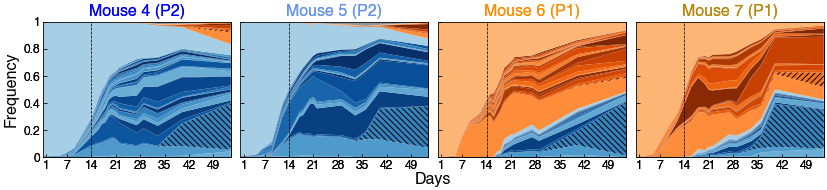

In [44]:
mouse_colors = {4:'blue', 5:'cornflowerblue', 6:'darkorange', 7:'darkgoldenrod'}
mice_in_each_col = [(4,5,1,2,3), (6,7, 8,9,10)]

fig = plt.figure(figsize=(14, 2.5))
outer = mpl.gridspec.GridSpec(nrows=1, ncols=4, wspace=0.05, figure=fig)
outer_ax = fig.add_subplot(outer[:, :])
outer_ax.set_xlabel('Days', fontsize=16, labelpad=14)
outer_ax.set_ylabel('Frequency', fontsize=16, labelpad=24)
util.turn_off_ax(outer_ax)

expt = 'E1'
condition_color = 'black'
mouse_plate_map = {4:2, 5:2, 6:1, 7:1}
MAX_CUTOFF = 1e-2 # minimum max freq to show as individual lineage
FINAL_FREQ = 1 # min final freq to show as individual lineage

for row, (m_set, colors, title) in enumerate( zip(mice_in_each_col, ['Blues', 'Oranges', 'Reds'], ['SD (P2)', 'SD (P1)', 'MD (P1)']) ):
    large_indices = shared.find_large_barcodes(expt, [4,5,6,7], max_cutoff=MAX_CUTOFF, final_cutoff=FINAL_FREQ)
    ordered_indices, ordered_colors = shared.order_barcodes_by_pool(large_indices, shared.barcode_pool_assignments, [('P2', 'Blues'), 
                                                                                                                     ('P1', 'Oranges'), 
                                                                                                                     ('E1_ambiguous', 'Greys')], cg_at_end=False)
    for col, mouse in enumerate([4,5,6,7]):
        days, freqs = shared.make_muller_freqs(expt, mouse, ordered_indices, 18)
        # print(freqs[0][:60])
        ax = fig.add_subplot(outer[col])
        shared.muller_plot(ax, days, ordered_indices, freqs, ordered_colors, shared.highlight_barcode_hatches)

        ax.axvline(14, color='black', linestyle='dashed')
        ax.set_ylim(0, 1)
        ax.set_xlim(0, 54)

        ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
        ax.set_yticklabels([0, 0.2, 0.4, 0.6, 0.8, 1], fontsize=12)

        ax.set_xticks([1, 7, 14, 21, 28, 35, 42, 49])
        ax.set_xticklabels([1, 7, 14, 21, 28, 35, 42, 49], fontsize=12)
        ax.set_title(f'Mouse {mouse} (P{mouse_plate_map[mouse]})', fontsize=16, color=mouse_colors[mouse])

        if col > 0:
            ax.set_yticklabels([])
            
fig.savefig(f'../figures/fig2_E1_muller_cross_housed.pdf')


Single-day transmission

In [45]:
expt = 'E1'
max_dt = 3
max_day = 60
time_pts_M6 = shared.find_consecutive_timepoints(expt, [4,5], 6, max_dt=max_dt, max_day=max_day)
time_pts_M7 = shared.find_consecutive_timepoints(expt, [4,5], 7, max_dt=max_dt, max_day=max_day)
time_pts_M4 = shared.find_consecutive_timepoints(expt, [6,7], 4, max_dt=max_dt, max_day=max_day)
time_pts_M5 = shared.find_consecutive_timepoints(expt, [6,7], 5, max_dt=max_dt, max_day=max_day)
time_pts_dict = {4: (time_pts_M4, [6, 7]),
                 5: (time_pts_M5, [6, 7]),
                 6: (time_pts_M6, [4, 5]),
                 7: (time_pts_M7, [4, 5])}
consec_timepts_dict = {(day, day+1): {util.KELLY_COLORS[i]} for i, day in enumerate(range(14,23))}

read_array = shared.read_array
day0_freqs = {6:read_array[1]/read_array[1].sum(), 7:read_array[1]/read_array[1].sum(),
              4:read_array[0]/read_array[0].sum(), 5:read_array[0]/read_array[0].sum()}

transmission_dict = {m:{} for m in [4,5,6,7]}
P1_bool = shared.barcode_pool_assignments['P1'][1]
P2_bool = shared.barcode_pool_assignments['P2'][1]

rescale_migration = 2
max_groups = 2
min_barcodes = 30
for c, (recipient_mouse, barcode_pool_bool) in enumerate(zip([4,5,6,7],
                                                             [P1_bool, P1_bool, P2_bool, P2_bool])):  
    time_pts_recip, donor_mice = time_pts_dict[recipient_mouse]

    recipient_transmitted_ratios = []
    for i, time_pts in enumerate(time_pts_recip):
        t0, t1 = time_pts
        output_dict = shared.measure_transmission_in_interval(expt, recipient_mouse, donor_mice, t0, t1, 
                                                              pool_assignment_bool=barcode_pool_bool, coarse_grain_num_groups=max_groups, 
                                                              min_barcodes=min_barcodes, rescale_migration=rescale_migration)
        transmission_dict[recipient_mouse][(t0, t1)] = output_dict

with open(f'../data/pickled/E1_transmission_dict.pkl', 'wb') as f:
    pickle.dump(transmission_dict, f)

Not enough barcodes for 7 at 27 to 29


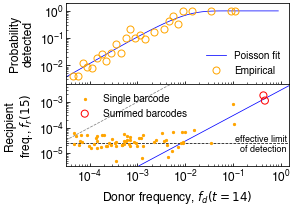

In [46]:
## main fig example 
recipient_mouse = 6
t0, t1 = 14, 15

example_transmission = transmission_dict[recipient_mouse][(t0, t1)]

donor_floor, recip_floor_t0, recip_floor_t1 = example_transmission['freq floors']
m_detect, m_detect_err  = example_transmission['detected inference']
bins, density = example_transmission['detected raw data']

m_ratio, m_ratio_err = example_transmission['ratio inference']
(donor_valid, recip_valid, donor_cg, recip_cg) =  example_transmission['ratio raw data']


plot_fig, plot_axs = plt.subplots(2, 1, figsize=(4,3))
plt.subplots_adjust(hspace=0.00)
detected_ax = plot_axs[0]

detected_ax.errorbar(bins, density, markersize=7, ecolor='orange', fmt='o', mfc='none', mec='orange', label='Empirical')
detected_ax.plot(bins, shared.p_transmit(bins, m_detect/rescale_migration/recip_floor_t1), color='blue', label='Poisson fit', zorder=0)
detected_ax.set_xscale('log')
detected_ax.set_yscale('log')
detected_ax.set_ylabel('Probability\ndetected', fontsize=12)
detected_ax.set_xlim(10**-4.5, 1.5)
detected_ax.set_ylim(2*10**-3, 2)

detected_ax.set_xticklabels([])
detected_ax.legend(loc=4, fontsize=10, frameon=False)

ratio_ax = plot_axs[1]
ratio_ax.scatter(donor_valid, recip_valid, s=5, color='orange', rasterized=True, label='Single barcode')
ratio_ax.scatter(donor_cg, recip_cg, s=50, marker='o', facecolor='none', edgecolors='red', rasterized=True, label='Summed barcodes')

ratio_ax.axline((10**-5, m_detect/rescale_migration*10**-5), (1, m_detect/rescale_migration), color='blue', zorder=0)
util.plot_diagonal(ratio_ax, color='grey')
ratio_ax.set_xscale('log')
ratio_ax.set_yscale('log')
ratio_ax.set_xlim(10**-4.5, 1.5)
ratio_ax.set_ylim(10**-5.5, 5*10**-3)
ratio_ax.set_xlabel(r'Donor frequency, $f_d(t=14)$', fontsize=12)
ratio_ax.set_ylabel('Recipient\nfreq., $f_r(15)$', fontsize=12)
ratio_ax.legend(loc=2, fontsize=10, frameon=False)

ratio_ax.axhline(recip_floor_t1, color='black', linestyle='dashed', zorder=0)
ratio_ax.text(0.99, 0.175, 'effective limit\n  of detection', transform=ratio_ax.transAxes, color='black', fontsize=9, ha='right')

plt.savefig(f'../figures/single_day_transmission_plot_M{recipient_mouse}_{t0}_{t1}.pdf')

t1 large 29
t1 large 36
t1 large 29
t1 large 36


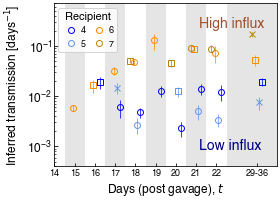

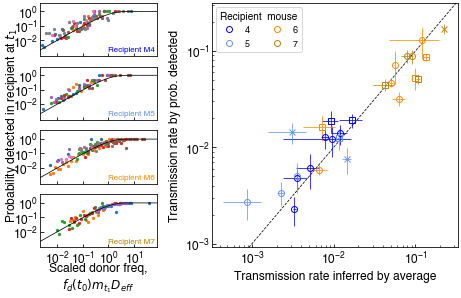

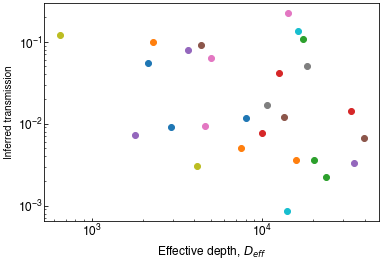

In [47]:
main_fig = plt.figure(figsize=(4, 3))
outer = mpl.gridspec.GridSpec(nrows=1, ncols=1, figure=main_fig)
outer_ax = main_fig.add_subplot(outer[:])
outer_ax.set_xlabel(r'Days (post gavage), $t$', fontsize=12)
outer_ax.set_ylabel("Inferred transmission [days$^{-1}$]", fontsize=12)

si_fig = plt.figure(figsize=(7.5, 4.5))
gs = plt.GridSpec(nrows = 4, ncols = 2, width_ratios=(1, 2.1), wspace=0.3, figure=si_fig)

compare_ax = si_fig.add_subplot(gs[:, 1])
outer_detect_ax = si_fig.add_subplot(gs[:, 0])
util.turn_off_ax(outer_detect_ax)
outer_detect_ax.set_ylabel('Probability detected in recipient at $t_1$', fontsize=12, labelpad=20)
outer_detect_ax.set_xlabel(r'Scaled donor freq,' +'\n' + r'$f_d(t_0)m_{t_1} D_{eff}$', fontsize=12, labelpad=15)

x, y = [], []

filtered_transmission_measures = {(expt, mouse):{'detect': [], 'ratio':[]} for mouse in transmission_dict.keys()}

fig, depth_ax = plt.subplots()
for r, recipient_m in enumerate([4,5,6,7]):
    transmission_measurements = transmission_dict[recipient_m]

    color = mouse_colors[recipient_m]

    detected_ax = si_fig.add_subplot(gs[r, 0])
    detected_ax.text(0.98, 0.05, f'Recipient M{recipient_m}', transform=detected_ax.transAxes, fontsize=8, ha='right', va='bottom', color=mouse_colors[recipient_m])
  
    for (t0, t1), measurements in transmission_measurements.items():
        if t1 <= 14 or measurements is None:
            continue
        if t1-t0 > 4:
            continue
        elif t1-t0 == 2 and (t0+1, t1) in transmission_measurements:
            continue
        elif t1-t0 == 3 and ((t0+1, t1) in transmission_measurements or (t0+2, t1) in transmission_measurements):
            continue
        elif t1-t0 == 4 and ((t0+1, t1) in transmission_measurements \
                             or (t0+2, t1) in transmission_measurements \
                                or (t0+3, t1) in transmission_measurements):
            continue
        
        # sampled_days.add(t1)
        if t1-t0 == 1:
            fmt = 'o'
        elif t1-t0 == 2:
            fmt = 's'
        elif t1-t0 == 3:
            fmt = 'x'
        elif t1-t0 == 4:
            fmt = '^'

        if t1 >= 18:
            filtered_transmission_measures[(expt, recipient_m)]['ratio'].append(m_ratio)
            filtered_transmission_measures[(expt, recipient_m)]['detect'].append(m_detect)
        if t1 > 25:
            print('t1 large', t1)
            t1 = 24 # for plotting
        
        
        donor_floor, recip_floor_t0, recip_floor_t1 = measurements['freq floors']
        m_detect, m_detect_err  = measurements['detected inference']
        bins, density = measurements['detected raw data']

        detected_ax.scatter(bins * m_detect / rescale_migration * recip_floor_t1**-1., density, s=5)        
        detected_ax.set_xscale('log')
        detected_ax.set_yscale('log')


        m_ratio, m_ratio_err = measurements['ratio inference']

        compare_ax.errorbar(m_ratio, m_detect, xerr=m_ratio_err, yerr=m_detect_err, color=mouse_colors[recipient_m], mfc='none', fmt=fmt)

        depth_ax.scatter( recip_floor_t1**-1., m_ratio )
        x.append(recip_floor_t1**-1.)
        y.append(m_detect)

        # outer_ax.scatter(t1, m_ratio)
        # outer_ax.errorbar([t1-(r-1.5)/6], m_ratio, yerr=m_ratio_err, color=color, mfc='none', fmt=fmt)
        outer_ax.errorbar([t1-(r-1.5)/6], m_detect, yerr=m_detect_err, color=color, mfc='none', fmt=fmt)
        


    detected_ax.plot(np.logspace(-3, 2, 101), 1-np.exp(-np.logspace(-3,2, 101)), color='black') #theory poisson
    detected_ax.set_xlim(2*10**-3, 80)
    detected_ax.set_ylim(8*10**-4, 4)
    detected_ax.set_xticks([10**-2, 10**-1, 10**0, 10])
    detected_ax.set_yticks([10**-2, 10**-1, 10**0])
    if r != 3:
        detected_ax.set_xticklabels([])

# format si fig
compare_ax.set_xscale('log')
compare_ax.set_yscale('log')
compare_ax.set_xlabel('Transmission rate inferred by average', fontsize=12)
compare_ax.set_ylabel('Transmission rate by prob. detected', fontsize=12)
util.plot_diagonal(compare_ax)

legend_markers = [mpl.lines.Line2D((0,0), (0,0), marker='o', lw=0, markersize=6, mfc='none', color=mouse_colors[recipient_m]) for recipient_m in [4,5,6,7]]
compare_ax.legend(legend_markers, [4,5,6,7], title='Recipient  mouse', ncol=2, loc=2, title_fontsize=10, fontsize=9, frameon=True)

main_fig.savefig(f'{plot_dir}/fig2_si_transmission_measurement_consistency.pdf')


depth_ax.set_xscale('log')
depth_ax.set_yscale('log')

notnan = ~np.isnan(y) & (np.array(x) > 3*10**3)
# print(scipy.stats.pearsonr(np.log(x)[notnan], np.log(y)[notnan]))

# format main fig
legend_markers = [mpl.lines.Line2D((0,0), (0,0), marker='o', lw=0, markersize=6, mfc='none', color=mouse_colors[recipient_m]) for recipient_m in [4,5,6,7]]
outer_ax.legend(legend_markers, [4,5,6,7], title='Recipient', ncol=2, loc=2, title_fontsize=11, fontsize=9, frameon=True, columnspacing=0.4, handletextpad=0.1)
outer_ax.set_yscale('log')
outer_ax.tick_params(axis='y', labelsize=12)
outer_ax.tick_params(axis='x', labelsize=9)

outer_ax.set_xticks( list(np.arange(14,23)) + [24])
outer_ax.set_xticklabels( [f'{e+14}' for e in np.arange(14, 23) - 14] + [r'29-36'] )
for i in np.arange(14.5, 22.5, 2):
    outer_ax.axvspan(i, i+1, color='grey', alpha=0.2, zorder=0,lw=0)
outer_ax.axvspan(22.5, 25, color='grey', alpha=0.2, zorder=0, lw=0)
outer_ax.set_xlim(outer_ax.get_xlim()[0], 25)

    
outer_ax.set_ylim(rescale_migration* 2*10**-4, rescale_migration * 3.5*10**-1)
outer_ax.text(0.65, 0.85, 'High influx', transform=outer_ax.transAxes, fontsize=14, color='sienna', ha='left')
outer_ax.text(0.65, 0.1, 'Low influx', transform=outer_ax.transAxes, fontsize=14, color='navy', ha='left')
# outer_ax.text(0.65, 0.85, 'High influx', transform=outer_ax.transAxes, fontsize=14, color='sienna', ha='left')
# outer_ax.text(0.65, 0.1, 'Low influx', transform=outer_ax.transAxes, fontsize=14, color='navy', ha='left')

plt.rcParams['svg.fonttype'] = 'none'
main_fig.savefig(f'../figures/migration_figB_transmission_over_time.pdf', transparent=True, bbox_inches='tight')
si_fig.savefig(f'../figures/sfig_monocolonization_transmission_consistency.pdf', transparent=True, bbox_inches='tight')

depth_ax.set_xlabel('Effective depth, $D_{eff}$', fontsize=12)
depth_ax.set_ylabel('Inferred transmission')

avg_transmission_measures = {}

for expt, mouse in [('E1', 4), ('E1', 5), ('E1', 6), ('E1', 7)]:
    ratio = np.array(filtered_transmission_measures[(expt, mouse)]['ratio'])
    detect = np.array(filtered_transmission_measures[(expt, mouse)]['detect'])


    mean_ratio = np.mean(filtered_transmission_measures[(expt, mouse)]['ratio'])
    mean_logratio = np.exp(np.mean(np.log(filtered_transmission_measures[(expt, mouse)]['ratio'])))

    mean_detect = np.mean(detect[~np.isnan(detect)])
    mean_logdetect = np.exp(np.mean(np.log(detect[~np.isnan(detect)])))

    avg_transmission_measures[ (expt, mouse) ] = {'ratio':mean_ratio, 'log_ratio':mean_logratio, 'detect':mean_detect, 'log_detect':mean_logdetect}

Example barcodes

/Users/daniel/Documents/GoodLab/btheta_barcoded_evolution/notebooks/methods/shared.py:656: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  recip_init = np.array(recip_init)


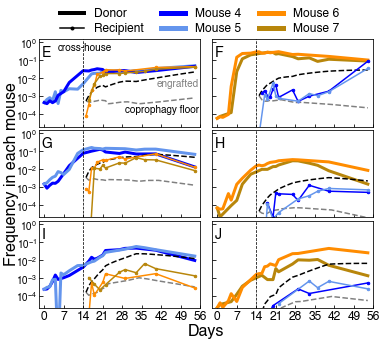

In [53]:
expt = 'E1'
mouse_colors = {6:'darkorange', 7:'darkgoldenrod', 4:'blue', 5:'cornflowerblue'}

example_barcodes = {
    # BARCODE: (DONOR, COLOR, ROW, COL)
    'AGACGACAATATCCACTTTC': ([5, 4], 'lightblue', 0, 0, 'E'),
    'TCCGTTAACCTTCATAGTTG':([6, 7], 'gold', 0, 1, 'F'),
    'CGGTTGCGGTATTACAAGTC': ([5, 4], 'lightblue', 1, 0, 'G'),
    'ATTAACCGTTGACCGCTGCT': ([6, 7], 'gold', 1, 1, 'H'),
    'TGTAGTAGGCATAATAACCC': ([5, 4], 'lightblue', 2, 0, 'I'),
    # 'CCGTTACATGCGTTCTTGGT': ([5, 4], 'lightblue', 2, 0, 'I'),
    'AACTACTCTTTGCATTTCCG': ([6, 7], 'gold', 2, 1, 'J')}


transmission_averages ={4:(avg_transmission_measures[(expt, 4)]['detect'] + avg_transmission_measures[(expt, 5)]['detect'])/2,
                        5:(avg_transmission_measures[(expt, 4)]['detect'] + avg_transmission_measures[(expt, 5)]['detect'])/2,
                        6:(avg_transmission_measures[(expt, 6)]['detect'] + avg_transmission_measures[(expt, 7)]['detect'])/2,
                        7:(avg_transmission_measures[(expt, 6)]['detect'] + avg_transmission_measures[(expt, 7)]['detect'])/2,}

panel_numbers = {(0,0):'E',
                 (0,1):'F',
                 (1,0):'G',
                 (1,1):'H',
                 (2,0):'I',
                 (2,1):'J'}

donor_recipient_map = {4:[6,7], 5:[6,7], 6:[4,5], 7:[4,5]}

fig = plt.figure(figsize=(6,5.5))
gs = plt.GridSpec(4,2, figure=fig, height_ratios = [0.3, 1,1,1], wspace=0.07, hspace=0.05)
outer_upper = fig.add_subplot(gs[2, :])
outer_lower = fig.add_subplot(gs[-1, :])
util.turn_off_ax(outer_upper)
util.turn_off_ax(outer_lower)
outer_lower.set_xlabel('Days', fontsize=16, labelpad=15)
outer_upper.set_ylabel('Frequency in each mouse', labelpad=20, fontsize=16)

legend_ax = fig.add_subplot(gs[0, :])
util.turn_off_ax(legend_ax)
legend_markers = [mpl.lines.Line2D((0,0), (0,0), lw=4, color='black'), mpl.lines.Line2D((0,0), (0,0), lw=1.5, marker='.', color='black')] +\
    [mpl.lines.Line2D((0,0), (0,0), lw=5, markersize=6, mfc='none', color=mouse_colors[recipient_m]) for recipient_m in [4,5,6,7]]
legend_ax.legend(legend_markers, ['Donor', 'Recipient', 'Mouse 4', 'Mouse 5', 'Mouse 6', 'Mouse 7'], loc=(0.05, -0.15), ncol=3, columnspacing=1.5, labelspacing=0.25, fontsize=12, frameon=False)


for barcode, (donors, color, row, col, panel) in example_barcodes.items():
    recipients = donor_recipient_map[donors[0]]
    freq_ax = fig.add_subplot(gs[row+1, col])

    shared.plot_barcode_trajectories(freq_ax, barcode, expt, donors, recipients, transmission_averages, mouse_colors, 14, plot_other_donors=True)

    freq_ax.set_yscale('log')
    freq_ax.set_yticks([10**-4, 10**-3, 10**-2, 10**-1, 1])
    freq_ax.set_ylim(2*10**-5, 1.5)
    freq_ax.axvline(14, color='black', linestyle='dashed')
    freq_ax.set_xticks([0,7,14, 21, 28, 35, 42, 49, 56])
    freq_ax.set_xticklabels([0,7, 14, 21, 28, 35, 42, 49, 56], fontsize=12)
    freq_ax.set_xlim(-2, 56)
    freq_ax.yaxis.set_tick_params(labelsize=10)

    # freq_ax.set_xlim(0, 10)

    freq_ax.text(0.02, 0.8, panel, transform=freq_ax.transAxes, fontsize=14, weight='heavy')
    if row == 0 and col == 0:
        freq_ax.text(0.99, 0.25, 'coprophagy floor', fontsize=10, color='black',
                     ha='right', va='top', transform=freq_ax.transAxes)
        freq_ax.text(0.99, 0.55, 'engrafted', fontsize=10, color='grey',
                     ha='right', va='top', transform=freq_ax.transAxes)

    if row!=2:
        freq_ax.set_xticklabels([])
    if col!=0:
        freq_ax.set_yticklabels([])

    if (row == 0) & (col == 0):
        freq_ax.text(14.5, 1, 'cross-house', ha='center', va='top', fontsize=10, color='black', rotation=0)


fig.savefig(f'../figures/fig2_example_engrafted_barcodes.pdf', transparent=True, bbox_inches='tight')

/Users/daniel/Documents/GoodLab/btheta_barcoded_evolution/notebooks/methods/shared.py:645: RuntimeWarning: divide by zero encountered in log
  log_slope = ( np.log(freq_after) - np.log(freq_before) ) / (nearest_day_after - nearest_day_before)
/Users/daniel/Documents/GoodLab/btheta_barcoded_evolution/notebooks/methods/shared.py:645: RuntimeWarning: invalid value encountered in subtract
  log_slope = ( np.log(freq_after) - np.log(freq_before) ) / (nearest_day_after - nearest_day_before)
/Users/daniel/Documents/GoodLab/btheta_barcoded_evolution/notebooks/methods/shared.py:646: RuntimeWarning: divide by zero encountered in log
  log_interp_freq = np.log(freq_before) + log_slope*(day - nearest_day_before)
/Users/daniel/Documents/GoodLab/btheta_barcoded_evolution/notebooks/methods/shared.py:646: RuntimeWarning: invalid value encountered in add
  log_interp_freq = np.log(freq_before) + log_slope*(day - nearest_day_before)


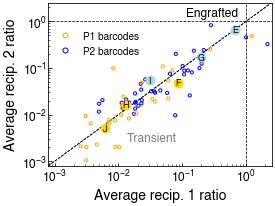

In [49]:
overlap_days_map = {}
for m1 in [4,5,6,7]:
    m1_days, m1_rows = shared.mouse_meta['E1'][m1][:2]
    m1_days = np.array(m1_days)
    for m2 in [4,5,6,7]:
        m2_days, m2_rows = shared.mouse_meta['E1'][m2][:2]
        m2_days = np.array(m2_days)

        m1m2_overlap = []
        m1_sub_rows = []
        m2_sub_rows = []

        for i, m2_day in enumerate(m2_days[::-1]):
            z = np.where(m1_days <= m2_day)[0][-1]
            m1_day = m1_days[z]

            if m2_day - m1_day <= 1:
                m1m2_overlap.append( m2_day )
                m1_sub_rows.append(z)
                m2_sub_rows.append(len(m2_days)-1-i)
            else:
                continue


        overlap_days_map[(m1,m2)] = [np.array(m1m2_overlap[::-1]),
                                     np.array(m1_sub_rows[::-1]),
                                     np.array(m2_sub_rows[::-1])]

expt = 'E1'
# mice_days = [shared.mouse_meta['E1'][mouse][0] for mouse in [4,5]]
fig, ax = plt.subplots(figsize=(4,3))
cutoff = 10**-2

P1_barcode_indices, P2_barcode_indices= shared.barcode_pool_assignments['P1'][0], shared.barcode_pool_assignments['P2'][0]

large_barcode_migration_ratios = {}
for (donors, recips, donor_barcode_indices, color) in [ [[4,5], [6,7], P2_barcode_indices, 'blue'], [[6,7], [4,5], P1_barcode_indices, 'orange']]:
    donor1, donor2 = donors
    recip1, recip2 = recips

    donor_overlap_days, m1_indices, m2_indices = overlap_days_map[(donor1,donor2)]

    donor1_days, donor1_rows = shared.mouse_meta[expt][donor1][:2]
    donor1_freqs = shared.freq_array[donor1_rows]
    interp1_days, interp1_freqs = shared.calc_interpolated_freqs((donor1_days, donor1_freqs))

    donor2_days, donor2_rows = shared.mouse_meta[expt][donor2][:2]
    donor2_freqs = shared.freq_array[donor2_rows]
    interp2_days, interp2_freqs = shared.calc_interpolated_freqs((donor2_days, donor2_freqs))

    recip1_days, recip1_rows = shared.mouse_meta[expt][recip1][:2]
    recip1_freqs = shared.freq_array[recip1_rows]
    recip1_floors = shared.Deff_array[recip1_rows]**-1.

    recip2_days, recip2_rows = shared.mouse_meta[expt][recip2][:2]
    recip2_freqs = shared.freq_array[recip2_rows]
    recip2_floors = shared.Deff_array[recip2_rows]**-1.

    x_lst = [ [], [] ]
    included_indices = []
    included_donor_freqs = [[],[]]
    for i in donor_barcode_indices:
        barcode = shared.barcodes[i]

        d1_freqs = donor1_freqs[:, i]
        d2_freqs = donor2_freqs[:, i]
        if np.max(d1_freqs[:]) < cutoff and np.max(d2_freqs[:]) < cutoff:
            continue
        included_indices.append(i)
        if np.median(d1_freqs[m1_indices]) > np.median(d2_freqs[m2_indices]): #if measured at higher frequency in donor 1 vs donor 2
            donor, donor_days, donor_freqs = donor1, donor1_days, d1_freqs #interp1_freqs[[i for i, day in enumerate(interp1_days) if day in donor1_days], i]
        else:
            donor, donor_days, donor_freqs = donor2, donor2_days, d2_freqs #interp2_freqs[[i for i, day in enumerate(interp2_days) if day in donor2_days], i]

        recip_ratios = []
        for r, (recip, recip_days, recip_freqs, recip_floors) in enumerate(zip([recip1, recip2], [recip1_days, recip2_days], [recip1_freqs[:, i], recip2_freqs[:, i]], [recip1_floors, recip2_floors])):
            overlap_days, d_indices, r_indices = overlap_days_map[(donor, recip)]

            past_xhouse = (overlap_days > 14)*(donor_freqs[d_indices] > 0)
            shared_donor_freqs = donor_freqs[d_indices][past_xhouse]
            shared_recip_freqs = recip_freqs[r_indices][past_xhouse]
            shared_recip_floors = recip_floors[r_indices][past_xhouse]
            shared_recip_freqs[shared_recip_freqs == 0] = shared_recip_floors[shared_recip_freqs == 0]/10


            ratio = np.mean(shared_recip_freqs / shared_donor_freqs)
            x_lst[r].append(ratio)
            recip_ratios.append((recip, ratio))

        large_barcode_migration_ratios[i] = {'donor':donor, 'recips':recip_ratios}

    discovery = np.array(x_lst[0])
    validation = np.array(x_lst[1])
    sorting = np.argsort(discovery)[::-1]
    ax.scatter(discovery, validation, s=10, facecolors='none', edgecolors=color)

    for i, idx in enumerate(included_indices):
        barcode = shared.barcodes[idx]
        if barcode in example_barcodes.keys():
            donors, color, row, col, panel = example_barcodes[barcode]

            ax.scatter(discovery[i], validation[i], marker='o', s=80, color=color)
            ax.text(discovery[i], validation[i], panel, fontsize=9, color='black',
                    ha='center', va='center')

    util.plot_diagonal(ax)


with open(f'{data_dir}/pickled/E1_large_barcode_migration_ratios.pkl', 'wb') as f:
    pickle.dump(large_barcode_migration_ratios, f)


legend_markers = [mpl.lines.Line2D((0,0), (0,0), marker='o', mfc='none', mec=col, markersize=5, lw=0) for col in ['orange', 'blue']]
ax.legend(legend_markers, ['P1 barcodes', 'P2 barcodes'], loc=(0.01, 0.65), fontsize=10, frameon=False, bbox_transform=ax.transAxes)

ax.set_xlabel('Average recip. 1 ratio', fontsize=14)
ax.set_ylabel('Average recip. 2 ratio', fontsize=14)
ax.text(0.35, 0.15, 'Transient', fontsize=12, transform=ax.transAxes, color='grey')
ax.text(0.85, 0.92, 'Engrafted', fontsize=12, transform=ax.transAxes, color='black', ha='right')
ax.set_xlim(8*10**-4, 2.5)
ax.set_ylim(8*10**-4, 2.5)
ax.set_xscale('log')
ax.set_yscale('log')
ax.axvline(1, color='black', linestyle='dashed', zorder=0)
ax.axhline(1, color='black', linestyle='dashed', zorder=0)


fig.savefig(f'../figures/fig2_mono_transmission_recip1_v_recip2.pdf', transparent=True, bbox_inches='tight')


/Users/daniel/Documents/GoodLab/btheta_barcoded_evolution/notebooks/methods/shared.py:645: RuntimeWarning: divide by zero encountered in log
  log_slope = ( np.log(freq_after) - np.log(freq_before) ) / (nearest_day_after - nearest_day_before)
/Users/daniel/Documents/GoodLab/btheta_barcoded_evolution/notebooks/methods/shared.py:645: RuntimeWarning: invalid value encountered in subtract
  log_slope = ( np.log(freq_after) - np.log(freq_before) ) / (nearest_day_after - nearest_day_before)
/Users/daniel/Documents/GoodLab/btheta_barcoded_evolution/notebooks/methods/shared.py:646: RuntimeWarning: divide by zero encountered in log
  log_interp_freq = np.log(freq_before) + log_slope*(day - nearest_day_before)
/Users/daniel/Documents/GoodLab/btheta_barcoded_evolution/notebooks/methods/shared.py:646: RuntimeWarning: invalid value encountered in add
  log_interp_freq = np.log(freq_before) + log_slope*(day - nearest_day_before)
/opt/anaconda3/envs/kim_barcodes/lib/python3.9/site-packages/numpy/core

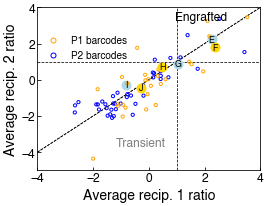

In [50]:
expt = 'E1'
# mice_days = [shared.mouse_meta['E1'][mouse][0] for mouse in [4,5]]
fig, ax = plt.subplots(figsize=(4,3))
cutoff = 10**-2

P1_barcode_indices, P2_barcode_indices= shared.barcode_pool_assignments['P1'][0], shared.barcode_pool_assignments['P2'][0]

large_barcode_migration_ratios = {}
for (donors, recips, donor_barcode_indices, color) in [ [[4,5], [6,7], P2_barcode_indices, 'blue'], [[6,7], [4,5], P1_barcode_indices, 'orange']]:
    donor1, donor2 = donors
    recip1, recip2 = recips

    donor_overlap_days, m1_indices, m2_indices = overlap_days_map[(donor1,donor2)]

    donor1_days, donor1_rows = shared.mouse_meta[expt][donor1][:2]
    donor1_freqs = shared.freq_array[donor1_rows]
    interp1_days, interp1_freqs = shared.calc_interpolated_freqs((donor1_days, donor1_freqs))

    donor2_days, donor2_rows = shared.mouse_meta[expt][donor2][:2]
    donor2_freqs = shared.freq_array[donor2_rows]
    interp2_days, interp2_freqs = shared.calc_interpolated_freqs((donor2_days, donor2_freqs))

    recip1_days, recip1_rows = shared.mouse_meta[expt][recip1][:2]
    recip1_freqs = shared.freq_array[recip1_rows]
    recip1_floors = shared.Deff_array[recip1_rows]**-1.

    recip2_days, recip2_rows = shared.mouse_meta[expt][recip2][:2]
    recip2_freqs = shared.freq_array[recip2_rows]
    recip2_floors = shared.Deff_array[recip2_rows]**-1.

    x_lst = [ [], [] ]
    included_indices = []
    included_donor_freqs = [[],[]]
    for i in donor_barcode_indices:
        barcode = shared.barcodes[i]

        d1_freqs = donor1_freqs[:, i]
        d2_freqs = donor2_freqs[:, i]
        if np.max(d1_freqs[:]) < cutoff and np.max(d2_freqs[:]) < cutoff:
            continue
        included_indices.append(i)
        if np.median(d1_freqs[m1_indices]) > np.median(d2_freqs[m2_indices]): #if measured at higher frequency in donor 1 vs donor 2
            donor, donor_days, donor_freqs = donor1, donor1_days, d1_freqs #interp1_freqs[[i for i, day in enumerate(interp1_days) if day in donor1_days], i]
        else:
            donor, donor_days, donor_freqs = donor2, donor2_days, d2_freqs #interp2_freqs[[i for i, day in enumerate(interp2_days) if day in donor2_days], i]

        recip_ratios = []
        for r, (recip, recip_days, recip_freqs, recip_floors) in enumerate(zip([recip1, recip2], [recip1_days, recip2_days], [recip1_freqs[:, i], recip2_freqs[:, i]], [recip1_floors, recip2_floors])):
            overlap_days, d_indices, r_indices = overlap_days_map[(donor, recip)]

            past_xhouse = (overlap_days > 14)*( donor_freqs[d_indices] > 1e-3)            
            shared_donor_freqs = donor_freqs[d_indices][past_xhouse]
            shared_recip_freqs = recip_freqs[r_indices][past_xhouse]
            shared_recip_floors = recip_floors[r_indices][past_xhouse]

            shared_recip_freqs[shared_recip_freqs == 0] = shared_recip_floors[shared_recip_freqs == 0]/10


            ratio = np.mean(shared_recip_freqs / shared_donor_freqs)

            if recip in [4,5]: tau = 0.008
            else: tau = 0.07
            x_lst[r].append( np.log(ratio/tau) )
            recip_ratios.append((recip, ratio))

        large_barcode_migration_ratios[i] = {'donor':donor, 'recips':recip_ratios}

    discovery = np.array(x_lst[0])
    validation = np.array(x_lst[1])
    sorting = np.argsort(discovery)[::-1]
    ax.scatter(discovery, validation, s=10, facecolors='none', edgecolors=color)

    for i, idx in enumerate(included_indices):
        barcode = shared.barcodes[idx]
        if barcode in example_barcodes.keys():
            donors, color, row, col, panel = example_barcodes[barcode]

            ax.scatter(discovery[i], validation[i], marker='o', s=80, color=color)
            ax.text(discovery[i], validation[i], panel, fontsize=9, color='black',
                    ha='center', va='center')

    util.plot_diagonal(ax)

legend_markers = [mpl.lines.Line2D((0,0), (0,0), marker='o', mfc='none', mec=col, markersize=5, lw=0) for col in ['orange', 'blue']]
ax.legend(legend_markers, ['P1 barcodes', 'P2 barcodes'], loc=(0.01, 0.65), fontsize=10, frameon=False, bbox_transform=ax.transAxes)

ax.set_xlabel('Average recip. 1 ratio', fontsize=14)
ax.set_ylabel('Average recip. 2 ratio', fontsize=14)
ax.text(0.35, 0.15, 'Transient', fontsize=12, transform=ax.transAxes, color='grey')
ax.text(0.85, 0.92, 'Engrafted', fontsize=12, transform=ax.transAxes, color='black', ha='right')
ax.set_xlim(-4, 4)
ax.set_ylim(-5, 4)
# ax.set_xscale('log')
# ax.set_yscale('log')
ax.axvline(1, color='black', linestyle='dashed', zorder=0)
ax.axhline(1, color='black', linestyle='dashed', zorder=0)

fig.savefig(f'../figures/fig2_mono_transmission_recip1_v_recip2.pdf')

/var/folders/x3/8f6xdlhn4hscmskkzs52dycc0000gn/T/ipykernel_67823/605857420.py:48: RuntimeWarning: invalid value encountered in true_divide
  fitness = np.log(f1/f0) / dt
/opt/anaconda3/envs/kim_barcodes/lib/python3.9/site-packages/matplotlib/axes/_axes.py:1103: RuntimeWarning: All-NaN axis encountered
  minx = np.nanmin(masked_verts[..., 0])
/opt/anaconda3/envs/kim_barcodes/lib/python3.9/site-packages/matplotlib/axes/_axes.py:1104: RuntimeWarning: All-NaN axis encountered
  maxx = np.nanmax(masked_verts[..., 0])


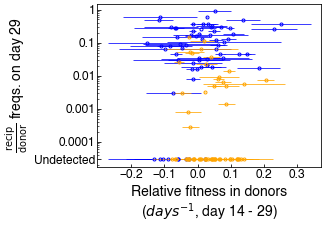

In [51]:
expt = 'E1'

## plot recipient/donor ratio vs growth rate in donor...
t_init, t_final = 14, 29
mouse_init_t = {4:14, 5:14, 6:14, 7:18} 
mouse_final_t = {4:t_final, 5:t_final, 6:t_final, 7:t_final}


fig, ax = plt.subplots(figsize=(4,3))

ref_barcodes = {25:'navy', 0:'peru',11:'blue',
                       37:'darkorange', 36:'lightblue', 41:'gold'}
large_barcode_migration_ratios = {}

for (donors, recips, (inoc_barcodes, inoc_bool), color) in [ [[4, 5], [6,7], shared.barcode_pool_assignments['P2'], 'blue'], [[6, 7], [4,5], shared.barcode_pool_assignments['P1'], 'orange']]:
    d1_freqs = shared.freq_array[ shared.mouse_meta[expt][donors[0]][1], :]
    d2_freqs = shared.freq_array[ shared.mouse_meta[expt][donors[1]][1], :]

    donor_init = shared.freq_array[ [shared.vivo_row_ids[(expt, donor, mouse_init_t[donor])] for donor in donors], :]
    donor_Dinit = shared.Deff_array[ [shared.vivo_row_ids[(expt, donor, mouse_init_t[donor])] for donor in donors]]

    donor_final = shared.freq_array[ [shared.vivo_row_ids[(expt, donor, mouse_final_t[donor])] for donor in donors], :]
    donor_Dfinal = shared.Deff_array[ [shared.vivo_row_ids[(expt, donor, mouse_init_t[donor])] for donor in donors]]
    donor_dt = np.array( [mouse_final_t[donor] - mouse_init_t[donor] for donor in donors] )

    recip_init = shared.freq_array[ [shared.vivo_row_ids[(expt, recip, mouse_init_t[recip])] for recip in recips], :]
    recip_final = shared.freq_array[ [shared.vivo_row_ids[(expt, recip, mouse_final_t[recip])] for recip in recips], :]
    recip_dt = np.array( [mouse_final_t[recip] - mouse_init_t[recip] for recip in recips] )

    ## calculate growth rates
    x_lst = [ [], [] ]

    for i, barcode in enumerate(shared.barcodes):
        if ~inoc_bool[i]:
            continue

        if np.max( np.min([donor_init[:, i], donor_final[:, i]], axis=0) ) < 1e-3:
            continue
        
        donor_growth = []
        for (f0, D0, f1, D1, dt) in zip(donor_init[:, i], donor_Dinit, donor_final[:, i], donor_Dfinal, donor_dt):
            f0, f1 = shared.maxmin_freqs([f0], D0, [f1], D1)
            fitness = np.log(f1/f0) / dt
            donor_growth.append(fitness[0])
        donor_growth = np.array(donor_growth)

        with np.errstate(divide='ignore'):
            recip_donor_ratio = recip_final[:, i] / np.mean(donor_final[:, i])
            recip_donor_ratio[recip_donor_ratio == 0] = 3e-5
        xerr = [[np.mean(donor_growth) - np.min(donor_growth)], [np.max(donor_growth) - np.mean(donor_growth)]]

        yerr = [[np.mean(recip_donor_ratio) - np.min(recip_donor_ratio)], [np.max(recip_donor_ratio) - np.mean(recip_donor_ratio)]]

        ax.errorbar( np.mean(donor_growth), np.mean(recip_donor_ratio), xerr=xerr, fmt='o', markersize=3,
                    color=color, markerfacecolor='none')  
        

ax.set_xlabel('Relative fitness in donors\n($days^{-1}$, day 14 - 29)', fontsize=14)
ax.set_ylabel(r'$\frac{\mathrm{recip}}{\mathrm{donor}}$ freqs. on day 29', fontsize=14)
ax.set_yscale('log')
# ax.set_xscale('log')
ax.set_xticks([-0.2, -0.1, 0.0, 0.1, 0.2, 0.3])
ax.set_yticks([3*10**-5, 10**-4, 10**-3, 10**-2, 10**-1, 1])
ax.set_yticklabels(['Undetected', 10**-4, 10**-3, 10**-2, 10**-1, 1], fontsize=12)

fig.savefig(f'../figures/sfig_growth_vs_engraftment.pdf', transparent=True, bbox_inches='tight')